In [1]:
# load packages
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#plt.rcParams.update({"text.usetex": True, "font.family": "Times"})

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_moons
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
import shap
import pickle



In [2]:
# load data from a csv file
# upzip()
df = pd.read_csv('data/spotify_data.csv') 
pd.get_option("display.max_columns")
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [3]:
df.shape

(169909, 19)

### Splitting

In [4]:
from sklearn.model_selection import train_test_split 

X, y = df.loc[:, df.columns != 'popularity'], df['popularity']  

### Preprocessing

In [5]:
# add ordinal feature of year bins 
onehot_ftrs = ['explicit', 'key','mode']
std_ftrs = ['acousticness','danceability','duration_ms','energy','liveness','loudness','tempo','valence']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)]) 

### Training the Models

In [40]:
def MLpipe_RMSE(X, y, preprocessor, ML_algo, param_grid, KNN=False):
    # we will loop through nr_states random states so we will return nr_states test scores and nr_states trained models
    nr_states = 5
    test_scores = np.zeros(nr_states)
    final_models = []

    # loop through the different random states
    for i in range(nr_states):
        print('\nrandoms state '+str(i+1))

        # first split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

        # second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

        # preprocess the sets
        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)

        # we save the train and validation scores
        # the validation scores are necessary to select the best model
        # we save the train score just to check things
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []

        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print('   ',params)
            if KNN:
                clf = ML_algo(**params, n_jobs=-1)
            else:
                clf = ML_algo(**params,random_state = 42*i) # initialize the classifier
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) # save it
            # calculate train and validation accuracy scores
            y_train_pred = clf.predict(X_train_prep)
            y_val_pred = clf.predict(X_val_prep)
            
            # RMSE score
#             train_score[p] = (mean_squared_error(y_train,y_train_pred))**0.5
#             val_score[p] = (mean_squared_error(y_val,y_val_pred))**0.5
            
            # r2 score
            train_score[p] = r2_score(y_train,y_train_pred)
            val_score[p] = r2_score(y_val,y_val_pred)
            
            print('   ','train score:', train_score[p],'val score:', val_score[p])

        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
        print('corresponding validation score:',np.max(val_score))
        # collect and save the best model
        final_models.append(models[np.argmax(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        
#         test_scores[i] = (mean_squared_error(y_test,y_test_pred))**0.5
        test_scores[i] = r2_score(y_test,y_test_pred)
        
        print('test score:',test_scores[i])
        
    return final_models, test_scores


### Lasso

In [22]:
from sklearn.linear_model import Lasso
# parameter grid
alpha = np.logspace(-4,3,8) 
param_grid = {'alpha': alpha}

# initialize ML algorithm 
ML_algo = Lasso 
    
# find best model and test score
best_models_lasso, test_scores_lasso = MLpipe_RMSE(X, y, prep, ML_algo, param_grid)



randoms state 1
    {'alpha': 0.0001}
    train score: 0.4257654833239577 val score: 0.4304348533673519
    {'alpha': 0.001}
    train score: 0.4257650802076739 val score: 0.43044389137382477
    {'alpha': 0.01}
    train score: 0.42572952902955863 val score: 0.4305020572391507
    {'alpha': 0.1}
    train score: 0.4248721562250417 val score: 0.4297039775321454
    {'alpha': 1.0}
    train score: 0.4073341814777258 val score: 0.41114039827523907
    {'alpha': 10.0}
    train score: 0.13467500964090684 val score: 0.1348899326409967
    {'alpha': 100.0}
    train score: 0.0 val score: -1.2153721164587239e-05
    {'alpha': 1000.0}
    train score: 0.0 val score: -1.2153721164587239e-05
best model parameters: {'alpha': 0.01}
corresponding validation score: 0.4305020572391507
test score: 0.4304087483150243

randoms state 2
    {'alpha': 0.0001}
    train score: 0.42824537369352744 val score: 0.42736533765204654
    {'alpha': 0.001}
    train score: 0.42824496583323013 val score: 0.42736965

In [23]:
# save the model
file = open('results/lasso_models.save', 'wb')
pickle.dump((best_models_lasso, test_scores_lasso), file)
file.close()

In [34]:
# uncertainty 
print("\nMean of test scores = ", np.mean(test_scores_lasso))
print("Standard deviation of test scores = ", np.std(test_scores_lasso))


Mean of test scores =  0.42868018324711754
Standard deviation of test scores =  0.0035444156443941604


### Ridge

In [25]:
# parameter grid
alpha = np.logspace(-4,3,8)
param_grid = {'alpha': alpha}

# initialize ML algorithm 
ML_algo = Ridge 
    
# find best model and test score
best_models_ridge, test_scores_ridge = MLpipe_RMSE(X, y, preprocessor, ML_algo, param_grid)



randoms state 1
    {'alpha': 0.0001}
    train score: 0.42576548739597764 val score: 0.4304338086184827
    {'alpha': 0.001}
    train score: 0.42576548739597764 val score: 0.43043380855731683
    {'alpha': 0.01}
    train score: 0.42576548739597275 val score: 0.430433807945655
    {'alpha': 0.1}
    train score: 0.42576548739548425 val score: 0.43043380182854407
    {'alpha': 1.0}
    train score: 0.4257654873466331 val score: 0.4304337406083423
    {'alpha': 10.0}
    train score: 0.4257654824667906 val score: 0.4304331235036578
    {'alpha': 100.0}
    train score: 0.4257649996248861 val score: 0.43042646872440027
    {'alpha': 1000.0}
    train score: 0.42572093085517915 val score: 0.430316896035862
best model parameters: {'alpha': 0.0001}
corresponding validation score: 0.4304338086184827
test score: 0.4303334739698933

randoms state 2
    {'alpha': 0.0001}
    train score: 0.42824537781481 val score: 0.42736481734630316
    {'alpha': 0.001}
    train score: 0.4282453778148101 v

In [26]:
# save the model
file = open('results/ridge_models.save', 'wb')
pickle.dump((best_models_ridge, test_scores_ridge), file)
file.close()

In [27]:
# uncertainty 
print("\nMean of test scores = ", np.mean(test_scores_ridge))
print("Standard deviation of test scores = ", np.std(test_scores_ridge))


Mean of test scores =  0.42866237675156205
Standard deviation of test scores =  0.003523870295314795


### Elastic Net

In [28]:
# parameter grid
param_grid = {"alpha": [0.001, 0.01, 0.03, 0.05, 0.1], # take more smaller vals
              "l1_ratio": np.arange(0.1, 0.9, 0.1)}

# initialize ML algorithm 
ML_algo = ElasticNet 
    
# find best model and test score
best_models_EN, test_scores_EN = MLpipe_RMSE(X, y, preprocessor, ML_algo, param_grid)



randoms state 1
    {'l1_ratio': 0.1, 'alpha': 0.001}
    train score: 0.4257650348078279 val score: 0.4304281565978144
    {'l1_ratio': 0.2, 'alpha': 0.001}
    train score: 0.42576507911148986 val score: 0.43042996542287304
    {'l1_ratio': 0.30000000000000004, 'alpha': 0.001}
    train score: 0.42576511369963566 val score: 0.4304317454255596
    {'l1_ratio': 0.4, 'alpha': 0.001}
    train score: 0.4257651385833493 val score: 0.4304335178693569
    {'l1_ratio': 0.5, 'alpha': 0.001}
    train score: 0.4257651537325543 val score: 0.43043528355831007
    {'l1_ratio': 0.6, 'alpha': 0.001}
    train score: 0.42576515911907986 val score: 0.4304370429221174
    {'l1_ratio': 0.7000000000000001, 'alpha': 0.001}
    train score: 0.42576515467544274 val score: 0.43043879408322594
    {'l1_ratio': 0.8, 'alpha': 0.001}
    train score: 0.42576514038279634 val score: 0.4304405385871113
    {'l1_ratio': 0.1, 'alpha': 0.01}
    train score: 0.4257241991839672 val score: 0.43033545794432404
    {'l1

    train score: 0.42694272178772097 val score: 0.42702687119656846
    {'l1_ratio': 0.7000000000000001, 'alpha': 0.1}
    train score: 0.4271419637252327 val score: 0.4271203392191526
    {'l1_ratio': 0.8, 'alpha': 0.1}
    train score: 0.4273057442229883 val score: 0.42716944876686425
best model parameters: {'l1_ratio': 0.30000000000000004, 'alpha': 0.03}
corresponding validation score: 0.4275465623960567
test score: 0.4259488926019326

randoms state 3
    {'l1_ratio': 0.1, 'alpha': 0.001}
    train score: 0.4286975439132278 val score: 0.42364312046711694
    {'l1_ratio': 0.2, 'alpha': 0.001}
    train score: 0.4286975927506672 val score: 0.42364230248886925
    {'l1_ratio': 0.30000000000000004, 'alpha': 0.001}
    train score: 0.4286976308051823 val score: 0.4236415078653549
    {'l1_ratio': 0.4, 'alpha': 0.001}
    train score: 0.4286976579545232 val score: 0.4236407483378557
    {'l1_ratio': 0.5, 'alpha': 0.001}
    train score: 0.42869767382012103 val score: 0.4236399746234283
  

    train score: 0.4287102534938033 val score: 0.4184701293551655
    {'l1_ratio': 0.2, 'alpha': 0.1}
    train score: 0.42903557287840055 val score: 0.4187306186091191
    {'l1_ratio': 0.30000000000000004, 'alpha': 0.1}
    train score: 0.4293349555832848 val score: 0.418965328080386
    {'l1_ratio': 0.4, 'alpha': 0.1}
    train score: 0.42961632148688533 val score: 0.4191657101142988
    {'l1_ratio': 0.5, 'alpha': 0.1}
    train score: 0.4298660719432962 val score: 0.4193286017667819
    {'l1_ratio': 0.6, 'alpha': 0.1}
    train score: 0.43010983177554407 val score: 0.4194725514541805
    {'l1_ratio': 0.7000000000000001, 'alpha': 0.1}
    train score: 0.4303224634573807 val score: 0.41957843907767867
    {'l1_ratio': 0.8, 'alpha': 0.1}
    train score: 0.4304828263951477 val score: 0.41962510163788835
best model parameters: {'l1_ratio': 0.1, 'alpha': 0.01}
corresponding validation score: 0.42015438653905857
test score: 0.424074909385162

randoms state 5
    {'l1_ratio': 0.1, 'alpha':

In [29]:
# save the model
file = open('results/elasticnet_models.save', 'wb')
pickle.dump((best_models_EN, test_scores_EN), file)
file.close()

In [30]:
# uncertainty
print("\nMean of test scores = ", np.mean(test_scores_EN))
print("Standard deviation of test scores = ", np.std(test_scores_EN))


Mean of test scores =  0.42864581548316527
Standard deviation of test scores =  0.00352281899016998


### Random Forest

In [19]:
# parameter grid 
param_grid = {
              'max_depth': [3, 7, 11, 15], # since there are 11 features here, and 
                                                             # we should use max depth such that it 
                                                             # is equal to or less than the number 
                                                             # of features in the dataset
              'max_features': [0.5,0.75,1.0]
              } 

# initialize ML algorithm 
ML_algo = RandomForestRegressor

# find best model and test score
best_models_RF, test_scores_RF = MLpipe_RMSE(X, y, preprocessor, ML_algo, param_grid)

print("\nMean of test scores = ", np.mean(test_scores))
print("Standard deviation of test scores = ", np.std(test_scores))


randoms state 1
    {'max_features': 0.5, 'max_depth': 3}
    train score: 0.47821471260797355 val score: 0.47651900000790703
    {'max_features': 0.75, 'max_depth': 3}
    train score: 0.4824126575692216 val score: 0.48029730264014103
    {'max_features': 1.0, 'max_depth': 3}
    train score: 0.47052278548407567 val score: 0.4678820620714471
    {'max_features': 0.5, 'max_depth': 7}
    train score: 0.5694253360845449 val score: 0.5615443643738545
    {'max_features': 0.75, 'max_depth': 7}
    train score: 0.5717347746414354 val score: 0.562447388631353
    {'max_features': 1.0, 'max_depth': 7}
    train score: 0.5701711941076968 val score: 0.5602825564838708
    {'max_features': 0.5, 'max_depth': 11}
    train score: 0.6453134656655917 val score: 0.5916250350875132
    {'max_features': 0.75, 'max_depth': 11}
    train score: 0.6502178918249091 val score: 0.5919839542847909
    {'max_features': 1.0, 'max_depth': 11}
    train score: 0.6523880727524336 val score: 0.5896808899778558
  

NameError: name 'test_scores' is not defined

In [20]:
# save the model
file = open('results/forest_models.save', 'wb')
pickle.dump((best_models_RF, test_scores_RF), file)
file.close()

In [21]:
# uncertainty
print("\nMean of test scores = ", np.mean(test_scores_RF))
print("Standard deviation of test scores = ", np.std(test_scores_RF))


Mean of test scores =  0.6008982675946799
Standard deviation of test scores =  0.0022965998429991447


### KNN

In [ ]:
# parameter grid 
param_grid = {
              'n_neighbors': [1, 3, 10, 30], 
              'weights': ['distance', 'uniform']
              } 

# initialize ML algorithm 
ML_algo = KNeighborsRegressor
print(ML_algo)

# find best model and test score
best_models_KNN, test_scores_KNN = MLpipe_RMSE(X, y, preprocessor, ML_algo, param_grid, KNN=True)

print("\nMean of test scores = ", np.mean(test_scores))
print("Standard deviation of test scores = ", np.std(test_scores))

In [59]:
# save the model
file = open('results/knn_models.save', 'wb')
pickle.dump((best_models_KNN, test_scores_KNN), file)
file.close()

In [65]:
# uncertainty
print("\nMean of test scores = ", np.mean(test_scores_KNN))
print("Standard deviation of test scores = ", np.std(test_scores_KNN))


Mean of test scores =  0.54473507644975
Standard deviation of test scores =  0.0021384974121354244


### XGBoost

In [42]:
random_states = [1, 2, 3, 4, 5]
max_depths = [1, 10, 30, 50]
train_r2, CV_r2, test_r2 = [], [], []

best_models_xgb = []
test_scores_xgb = []

for rs in random_states:
    print('\nrandoms state '+str(rs))
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=rs)
    X_CV, X_test, y_CV, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=rs)

    X_train_prep = prep.fit_transform(X_train)
    X_CV_prep = prep.transform(X_CV)
    X_test_prep = prep.transform(X_test)

    df_train = pd.DataFrame(data=X_train_prep)
    df_CV = pd.DataFrame(data=X_CV_prep)
    df_test = pd.DataFrame(data=X_test_prep)
    
    best_testscore = 0
    best_maxdepth = 0 
    
    models = []
    
    for md in max_depths:
        print('   ', 'max depth:', md)
        param_grid = {"learning_rate": [0.03], 
                  "n_estimators": [100], 
                  "missing": [np.nan], 
                  "max_depth": [md],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}
        
        XGB = xgboost.XGBRegressor(random_state=rs, n_jobs=-1)
        XGB.set_params(**ParameterGrid(param_grid)[0])
        XGB.fit(df_train,y_train,early_stopping_rounds=20,eval_set=[(df_CV, y_CV)],verbose=False)
        models.append(XGB)
        
        y_train_pred = XGB.predict(df_train)
        y_CV_pred = XGB.predict(df_CV)
        y_test_pred = XGB.predict(df_test)
        
        r2_train = r2_score(y_train, y_train_pred)
        r2_CV = r2_score(y_CV, y_CV_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        train_r2.append(r2_train)
        train_r2.append(r2_CV)
        train_r2.append(r2_test)
        
        print('   ','train score:', r2_train,'val score:', r2_CV)
        
        if r2_test > best_testscore:
            best_testscore = r2_test
            best_maxdepth = md
    
    print('Best test score: ', best_testscore)
    print('Best max depth: ', best_maxdepth)
    best_models_xgb.append(models[np.argmax(r2_CV)])
    test_scores_xgb.append(best_testscore)
    


randoms state 1
    max depth: 1
    train score: 0.42137600828906885 val score: 0.42537454741721537
    max depth: 10
    train score: 0.676328200335562 val score: 0.5955677963327901
    max depth: 30
    train score: 0.9487973733239556 val score: 0.5842761251638833
    max depth: 50
    train score: 0.9511209424036425 val score: 0.5828667447087837
Best test score:  0.5902910959181601
Best max depth:  10

randoms state 2
    max depth: 1
    train score: 0.42138282201948574 val score: 0.42268534566458504
    max depth: 10
    train score: 0.676041259322874 val score: 0.5922600754593023
    max depth: 30
    train score: 0.9488813473359935 val score: 0.5794042720459923
    max depth: 50
    train score: 0.9509809255902704 val score: 0.5790170951140625
Best test score:  0.5966382890145991
Best max depth:  10

randoms state 3
    max depth: 1
    train score: 0.4199840370962179 val score: 0.42781988317379127
    max depth: 10
    train score: 0.6744295174916917 val score: 0.597522675383

In [101]:
print(df_train, name=)
df_train.rename(columns={"0": "explicit_0", "1": "c", "2", })

         0    1    2    3    4    5    6    7    8    9   ...   14   15  \
0       1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
1       1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0   
2       1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
3       1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  1.0   
4       1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  1.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
101940  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
101941  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0   
101942  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
101943  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
101944  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  1.0  0.0   

              16        17        18        19        20        21        22  \
0       1.155211 -1

In [43]:
# save the model
file = open('results/xgb_models.save', 'wb')
pickle.dump((best_models_xgb, test_scores_xgb), file)
file.close()

In [44]:
# uncertainty
print("\nMean of test scores = ", np.mean(test_scores_xgb))
print("Standard deviation of test scores = ", np.std(test_scores_xgb))


Mean of test scores =  0.5918587796003845
Standard deviation of test scores =  0.0034727994423394966


### Baseline model

In [6]:
# baseline model and score
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=4)
X_CV, X_test, y_CV, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=4)

X_train_prep = prep.fit_transform(X_train)
X_CV_prep = prep.transform(X_CV)
X_test_prep = prep.transform(X_test)

df_train = pd.DataFrame(data=X_train_prep)
df_CV = pd.DataFrame(data=X_CV_prep)
df_test = pd.DataFrame(data=X_test_prep)

base_score = r2_score(y_train, DummyRegressor(strategy="mean").fit(X_train_prep, y_train).predict(X_train_prep))
print("Baseline score: ", base_score)


Baseline score:  0.0


## Model Comparison

In [7]:
# load models and corresponding scores
file = open('models/lasso_models.save', 'rb')
best_models_lasso, test_scores_lasso = pickle.load(file)
file.close()

file = open('models/ridge_models.save', 'rb')
best_models_ridge, test_scores_ridge = pickle.load(file)
file.close()

file = open('models/elasticnet_models.save', 'rb')
best_models_EN, test_scores_EN = pickle.load(file)
file.close()

file = open('models/forest_models.save', 'rb')
best_models_RF, test_scores_RF = pickle.load(file)
file.close()

# file = open('results/knn_models.save', 'rb')
# best_models_KNN, test_scores_KNN = pickle.load(file)
# file.close()

file = open('models/xgb_models.save', 'rb')
best_models_xgb, test_scores_xgb = pickle.load(file)
file.close()



lasso is 122.52840592783126 standard deviations above the baseline
ridge is 123.23245028324068 standard deviations above the baseline
elastic_net is 123.25435225046023 standard deviations above the baseline
random_forest is 256.79894471834376 standard deviations above the baseline
knn is 256.0491729721629 standard deviations above the baseline
xgb is 171.61078164896156 standard deviations above the baseline


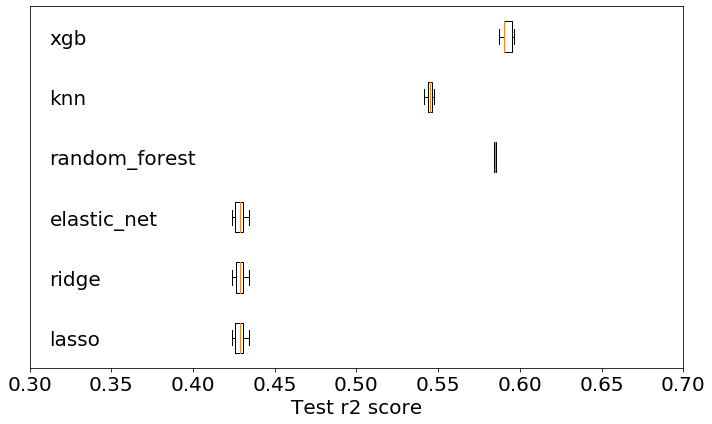

In [8]:
# compare models 
names = ['lasso', 'ridge', 'elastic_net', 'random_forest', 'knn', 'xgb']
models = [best_models_lasso, best_models_ridge, best_models_EN, best_models_RF, best_models_KNN, best_models_xgb]
scores = [test_scores_lasso, test_scores_ridge, test_scores_EN, test_scores_RF, test_scores_KNN, test_scores_xgb]

for i in range(len(models)):
    std_dev = (np.max(scores[i] - base_score) / np.std(scores[i]))
    print(str(names[i]), 'is', str(std_dev),'standard deviations above the baseline')

plt.figure(figsize=(10,6))
plt.boxplot([scores[i] for i in range(len(models))], vert=False, labels=[names[i] for i in range(len(models))], showfliers=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, ha="left")
plt.tick_params(axis="y", pad=-20, length=0)
plt.xlabel(u"Test r2 score", fontsize=20)
plt.xlim(0.3, 0.7)
plt.tight_layout()
plt.savefig('figures/testscores_boxplot.png', format='png', dpi=300)

In [ ]:
from statistics import mean, stdev

mean_scores = [mean(score) for score in scores]
stdev_scores = [stdev(score) for score in scores]

plt.bar(names, mean_scores, yerr=stdev_scores, capsize=2)
plt.ylim([0.4,0.7])
plt.xticks(rotation=-45)
plt.grid(axis='y')
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.title("R2 Score for each Model")
plt.savefig('figures/score_by_model.png', dpi=300, format='png')
plt.show()

## Feature importances 

In [10]:
# chosen model: XGBoost 

In [10]:
# feature names
enc = OneHotEncoder(sparse=False,handle_unknown='ignore') 
enc.fit(X_train[onehot_ftrs])
prepped_ftrs = list(enc.get_feature_names(onehot_ftrs)) 
prepped_ftrs += std_ftrs

In [11]:
test_scores_xgb

[0.5902910959181601,
 0.5966382890145991,
 0.5949430663321817,
 0.5870274235224713,
 0.5903940232145104]

In [12]:
best = best_models_xgb[1]
sorted_idx = np.argsort(best.feature_importances_)[::-1]
features = np.array(prepped_ftrs)[sorted_idx]
imp_scores = [x for x in np.sort(best.feature_importances_)[::-1] if x != 0]

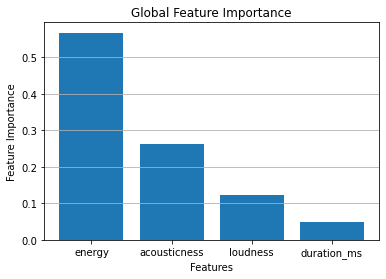

In [13]:
plt.bar(features[0:4], imp_scores, capsize=2)
plt.grid(axis='y')
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Global Feature Importance")
plt.savefig('figures/global_feature_imp.png', dpi=300, format='png')
plt.show()

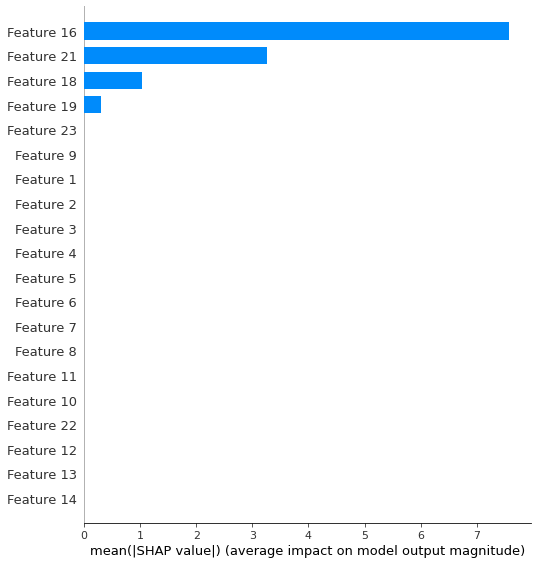

<Figure size 432x288 with 0 Axes>

In [21]:
# shap
explainer = shap.TreeExplainer(best)

np.random.seed(4)
X_shap = df_train.iloc[np.random.choice(len(X_train_prep), 100, replace=False)]
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_test_prep, plot_type="bar")
plt.savefig('figures/shap.png', dpi=300, format='png')